# Health Recommender System Using PySpark
Based on article by: [David Kabii](https://medium.com/analytics-vidhya/health-recommender-system-aceb558ed487)

### Imports

Importing the necessary libraries.

In [1]:
import random
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator

A spark session is created.

In [2]:
spark = SparkSession.builder.appName('DifferentialDiagnosisSystem').getOrCreate()

22/06/21 19:53:39 WARN Utils: Your hostname, LAPTOP-E7UTF4Q4 resolves to a loopback address: 127.0.1.1; using 192.168.111.88 instead (on interface eth0)
22/06/21 19:53:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/21 19:53:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Data Loading

Defining the dataset paths.

In [3]:
SPARSE_MATRIX_CSV = './dataset/symptoms-disease-weighted-rank_sparse-matrix.csv'
SYMPTOMS_CSV = './dataset/symptoms_id.csv'
DIAGNOSIS_CSV = './dataset/diseases_id.csv'

Loading each CSV file into data frames.

In [4]:
diff = spark.read.csv(SPARSE_MATRIX_CSV, header=True, inferSchema=True)
sym = spark.read.csv(SYMPTOMS_CSV, header=True, inferSchema=True)
dia = spark.read.csv(DIAGNOSIS_CSV, header=True, inferSchema=True)

Showing a preview of each data frame.

In [5]:
print('Symptoms: ')
sym.show(4)
print('Diagnosis: ')
dia.show(4)
print('Sparse Matrix: ')
diff.show(4)

Symptoms: 
+---+-------------------+
|syd|            symptom|
+---+-------------------+
|1.0|         pain chest|
|2.0|shortness of breath|
|3.0|          dizziness|
|4.0|           asthenia|
+---+-------------------+
only showing top 4 rows

Diagnosis: 
+---+--------------------+
|did|             disease|
+---+--------------------+
|  1|hypertensive disease|
|  2|            diabetes|
|  3|   depression mental|
|  4| depressive disorder|
+---+--------------------+
only showing top 4 rows

Sparse Matrix: 
+---+---+-------------------+
|syd|did|                wei|
+---+---+-------------------+
|1.0|  1|0.14285714285714285|
|2.0|  1|0.13186813186813187|
|3.0|  1|0.12087912087912088|
|4.0|  1|0.10989010989010989|
+---+---+-------------------+
only showing top 4 rows



Join the data frames based on IDs.

In [6]:
df = diff.join(sym, ['syd'], how='inner')
df = df.join(dia, ['did'], how='inner')
# df.show(4)
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease
0,1,1.0,0.142857,pain chest,hypertensive disease
1,1,2.0,0.131868,shortness of breath,hypertensive disease
2,1,3.0,0.120879,dizziness,hypertensive disease
3,1,4.0,0.109890,asthenia,hypertensive disease
4,1,5.0,0.098901,fall,hypertensive disease


### Feature Engineering

Indexes are created and each is assigned to a symptom name.

In [7]:
stringIndexer = StringIndexer(inputCol='symptom', outputCol='symptom_index')
model = stringIndexer.setHandleInvalid('skip').fit(df)
indexed = model.transform(df)
# indexed.show(4)
indexed_pandasDf = indexed.toPandas()
indexed_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index
0,1,1.0,0.142857,pain chest,hypertensive disease,14.0
1,1,2.0,0.131868,shortness of breath,hypertensive disease,0.0
2,1,3.0,0.120879,dizziness,hypertensive disease,77.0
3,1,4.0,0.109890,asthenia,hypertensive disease,9.0
4,1,5.0,0.098901,fall,hypertensive disease,66.0


The instance of the index is encoded in a created vector.

In [8]:
encoder = OneHotEncoder(dropLast=False, inputCol="symptom_index", outputCol="symptom_vec")
ohe = encoder.fit(indexed)
encoded = ohe.transform(indexed)
df = encoded
# df.show(4)
# print(df.count())
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec
0,1,1.0,0.142857,pain chest,hypertensive disease,14.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2.0,0.131868,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,3.0,0.120879,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,4.0,0.109890,asthenia,hypertensive disease,9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,5.0,0.098901,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Indexes are created and each is assigned to a disease name.

In [9]:
stringIndexer = StringIndexer(inputCol='disease', outputCol='disease_index')
model = stringIndexer.setHandleInvalid('skip').fit(df)
indexed = model.transform(df)
# indexed.show(4)
indexed_pandasDf = indexed.toPandas()
indexed_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index
0,1,1.0,0.142857,pain chest,hypertensive disease,14.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0
1,1,2.0,0.131868,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0
2,1,3.0,0.120879,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0
3,1,4.0,0.109890,asthenia,hypertensive disease,9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0
4,1,5.0,0.098901,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0


The instance of the index is encoded in a created vector.

In [10]:
encoder = OneHotEncoder(dropLast=False, inputCol="disease_index", outputCol="disease_vec")
ohe = encoder.fit(indexed)
encoded = ohe.transform(indexed)
df = encoded
# df.show(4)
# print(df.count())
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index,disease_vec
0,1,1.0,0.142857,pain chest,hypertensive disease,14.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2.0,0.131868,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,3.0,0.120879,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,4.0,0.109890,asthenia,hypertensive disease,9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,5.0,0.098901,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


The vectors are standardized by scaling.

In [11]:
cols = ['symptom', 'disease']
for col in cols:
  scaler = MinMaxScaler(inputCol=col+"_vec", outputCol=col+"_vec_scaled")
  scalerModel = scaler.fit(df)
  scaledData = scalerModel.transform(df)
  df = scaledData
# df.show(4)
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index,disease_vec,symptom_vec_scaled,disease_vec_scaled
0,1,1.0,0.142857,pain chest,hypertensive disease,14.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2.0,0.131868,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,3.0,0.120879,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,4.0,0.109890,asthenia,hypertensive disease,9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,5.0,0.098901,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


The scaled vectors are combined into a vector of features.

In [12]:
VectorAssembler = VectorAssembler(inputCols=['symptom_vec_scaled', 'disease_vec_scaled'], outputCol='features')
df = VectorAssembler.transform(df)
# df.show(4)
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index,disease_vec,symptom_vec_scaled,disease_vec_scaled,features
0,1,1.0,0.142857,pain chest,hypertensive disease,14.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2.0,0.131868,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,3.0,0.120879,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,4.0,0.109890,asthenia,hypertensive disease,9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,5.0,0.098901,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Clustering is applied.

In [13]:
kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(df.select('features'))
transformed = model.transform(df)
df = transformed
# df.show(4)
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index,disease_vec,symptom_vec_scaled,disease_vec_scaled,features,prediction
0,1,1.0,0.142857,pain chest,hypertensive disease,14.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,1,2.0,0.131868,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,1,3.0,0.120879,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,1,4.0,0.109890,asthenia,hypertensive disease,9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,1,5.0,0.098901,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


### Data Visualization

In [14]:
pca = PCA(k=2, inputCol='features', outputCol='pcaFeatures')
model = pca.fit(df)

22/06/21 19:54:11 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/06/21 19:54:11 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [15]:
result = model.transform(df).select('pcaFeatures')
pandasDf = result.toPandas()

In [16]:
dataX = []
dataY = []
for vec in pandasDf.values:
  dataX.extend([vec[0][0]])
  dataY.extend([vec[0][1]])

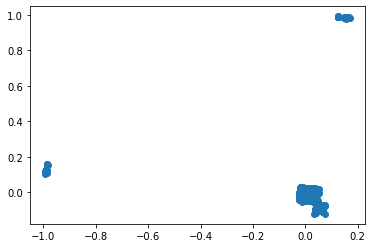

In [17]:
plt.scatter(dataX, dataY)
plt.show()

/home/paucabral/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


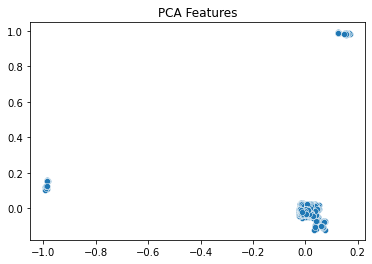

In [18]:
sns.scatterplot(dataX, dataY)
plt.title('PCA Features')
plt.show()

### Model Creation

Null values and the prediction column are dropped from the dataframe.

In [19]:
df = df.na.drop(subset=['syd', 'disease_index', 'wei'])
df = df.drop('prediction')
# df.show(4)
# print(type(df))
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index,disease_vec,symptom_vec_scaled,disease_vec_scaled,features
0,1,1.0,0.142857,pain chest,hypertensive disease,14.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2.0,0.131868,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,3.0,0.120879,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,4.0,0.109890,asthenia,hypertensive disease,9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,5.0,0.098901,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


The dataset was split into training and testing set.

In [20]:
splits = df.randomSplit([0.80, 0.20], 24)
train= splits[0]
test = splits[1]
print('Training set size: ', train.count())
print('Testing set size: ', test.count())

Training set size:  1732
Testing set size:  434


A recommender model utilizing Alternating Least Squares (ALS) is defined and trained using the training dataset.

In [21]:
rec = ALS(
          maxIter=10,
          regParam=0.01,
          userCol='syd',
          itemCol='disease_index',
          ratingCol='wei',
          nonnegative=True,
          coldStartStrategy='drop'
          )
rec_model = rec.fit(train)

### Model testing and evaluation

A summary of prediction is generated.

In [22]:
predicted_ratings = rec_model.transform(test)
# predicted_ratings.show(8)
predicted_ratings_pandasDf = predicted_ratings.toPandas()
predicted_ratings_pandasDf.head(8)

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index,disease_vec,symptom_vec_scaled,disease_vec_scaled,features,prediction
0,22,31.0,0.013228,mood depressed,anxiety state,81.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.025136
1,46,31.0,0.014706,mood depressed,obesity,81.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",47.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.037309
2,15,85.0,0.009524,swelling,anemia,36.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.030840
3,18,85.0,0.013072,swelling,insufficiency renal,36.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",34.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.052787
4,67,85.0,0.066176,swelling,lymphatic diseases,36.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",45.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.053419
5,69,85.0,0.025641,swelling,malignant neoplasm of breast,36.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",104.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.057368
6,73,85.0,0.025641,swelling,overload fluid,36.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",106.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.075185
7,91,137.0,0.014493,formication,suicide attempt,148.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.015399


The model is evaluated using Root Mean Square Error (RMSE), Normalized RMSE (NRMSE), Mean Squared Error (MSE), and Mean Absolute Error (MAE). 

In [23]:
evaluator = RegressionEvaluator(metricName='rmse', predictionCol='prediction', labelCol='wei')
rmse = evaluator.evaluate(predicted_ratings)
print('RMSE: ', rmse)

wei_max_value = df.agg({'wei': 'max'}).collect()[0][0]
wei_min_value = df.agg({'wei': 'min'}).collect()[0][0]
nrmse = rmse / (wei_max_value - wei_min_value)
print('NRMSE: ', nrmse)

evaluator = RegressionEvaluator(metricName='mse', predictionCol='prediction', labelCol='wei')
mse = evaluator.evaluate(predicted_ratings)
print('MSE: ', mse)

evaluator = RegressionEvaluator(metricName='mae', predictionCol='prediction', labelCol='wei')
mae = evaluator.evaluate(predicted_ratings)
print('MAE: ', mae)


RMSE:  0.045309694986503044
NRMSE:  0.09106800081445661
MSE:  0.0020529684597699388
MAE:  0.03441580754991253


### Saving and Loading the model

Saving the recommender model.

In [24]:
MODEL_PATH = './model/model_recommender'
rec_model.write().overwrite().save(MODEL_PATH)

22/06/21 19:54:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/06/21 19:54:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
22/06/21 19:54:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
22/06/21 19:54:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
22/06/21 19:54:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Loading the model.

In [25]:
MODEL_PATH = './model/model_recommender'
model = ALSModel.load(MODEL_PATH)

Transforming the complete data frame with respect to model prediction.

In [26]:
recommendations = model.transform(df).orderBy('prediction', ascending=False)
recommendations_df = recommendations.toPandas()
recommendations_df.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index,disease_vec,symptom_vec_scaled,disease_vec_scaled,features,prediction
0,148,213.0,0.500000,systolic murmur,decubitus ulcer,224.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",151.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.477823
1,148,302.0,0.333333,frail,decubitus ulcer,192.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",151.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.318580
2,150,243.0,0.333333,vision blurred,refractive error,231.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",150.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.311440
3,151,391.0,0.285714,sneeze,acute nasopharyngitis,291.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",148.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.262892
4,149,232.0,0.250000,abnormal sensation,polyneuropathy,234.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",147.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.231440


Exporting the recommendations data frame as `CSV` file.

In [27]:
RESULTS_PATH = "./result/"
import os
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

RECOMMENDATIONS_EXPORT_PATH = './result/recommendations_df.csv'
recommendations_df.to_csv(RECOMMENDATIONS_EXPORT_PATH, columns=['did', 'disease', 'syd', 'symptom', 'prediction'], index=False)

### Obtaining recommendations

To generate recommendations, the corresponding symptom IDs `syd` are acquired. The results below shows the list of recommendations based on the weights (according to the sparse matrix) and another one sorted by model prediction.

In [28]:
print('Symptoms: cough')
sydId = 46
df1a = df.filter(df['syd'] == sydId).select('syd', 'did', 'disease_index', 'disease', 'wei').orderBy('wei', ascending=False).distinct()
df1a.show(5)

recommendations = model.transform(df1a).orderBy('prediction', ascending=False)
print('Recommendations: ')
recommendations_df = recommendations.toPandas()
recommendations_df.head()

Symptoms: cough
+----+---+-------------+--------------------+-------------------+
| syd|did|disease_index|             disease|                wei|
+----+---+-------------+--------------------+-------------------+
|46.0|  7|         22.0|           pneumonia|                0.1|
|46.0| 10|        134.0|              asthma|0.17777777777777778|
|46.0|152|        131.0|pulmonary tubercu...|0.18181818181818182|
|46.0|116|         51.0|   carcinoma of lung|0.11666666666666667|
|46.0|115|         64.0|malignant neoplas...|0.11666666666666667|
+----+---+-------------+--------------------+-------------------+
only showing top 5 rows

Recommendations: 


,syd,did,disease_index,disease,wei,prediction
0,46.0,151,148.0,acute nasopharyngitis,0.190476,0.171147
1,46.0,10,134.0,asthma,0.177778,0.138643
2,46.0,16,122.0,chronic obstructive airway disease,0.145455,0.115312
3,46.0,130,141.0,pneumothorax,0.111111,0.096649
4,46.0,41,114.0,hepatitis C,0.121212,0.093935


In [29]:
print('Symptoms: pain chest, palpitation, shortness of breath, sweat')
sydId1 = 'pain chest'
sydId2 = 'palpitation'
sydId3 = 'shortness of breath'
sydId4 = 'sweat'
df1a = df.filter((df['symptom'] == sydId1) | (df['symptom'] == sydId2) |
                 (df['symptom'] == sydId3) | (df['symptom'] == sydId4)).select('syd', 'did', 'disease_index', 'disease', 'wei').orderBy('wei', ascending=False)
df1a.show()

recommendations = model.transform(df1a).orderBy('prediction', ascending=False)
print('Recommendations: ')
recommendations_df = recommendations.toPandas()
recommendations_df.head()


Symptoms: pain chest, palpitation, shortness of breath, sweat
+---+---+-------------+--------------------+-------------------+
|syd|did|disease_index|             disease|                wei|
+---+---+-------------+--------------------+-------------------+
|2.0|103|        149.0|      kidney disease| 0.2857142857142857|
|2.0|  8|        146.0|failure heart con...|               0.25|
|2.0| 83|        138.0|hypertension pulm...|                0.2|
|1.0|103|        149.0|      kidney disease|0.19047619047619047|
|1.0|  5|        123.0|coronary arterios...|0.18181818181818182|
|1.0|  6|        124.0|coronary heart di...|0.18181818181818182|
|2.0| 16|        122.0|chronic obstructi...|0.18181818181818182|
|2.0| 98|        132.0|tricuspid valve i...|0.18181818181818182|
|2.0| 42|        116.0|peripheral vascul...|0.16666666666666666|
|2.0| 10|        134.0|              asthma|0.15555555555555556|
|1.0|152|        131.0|pulmonary tubercu...|0.14545454545454545|
|2.0|  5|        123.0|coron

,syd,did,disease_index,disease,wei,prediction
0,2.0,103,149.0,kidney disease,0.285714,0.220263
1,1.0,103,149.0,kidney disease,0.190476,0.192690
2,2.0,83,138.0,hypertension pulmonary,0.200000,0.155587
3,1.0,6,124.0,coronary heart disease,0.181818,0.146402
4,1.0,5,123.0,coronary arteriosclerosis,0.181818,0.142654


In [30]:
result_df = recommendations_df[['disease', 'prediction']]
df = result_df.groupby('disease')['prediction'].sum().sort_values(ascending=False)
df

disease
kidney disease                          0.412953
coronary heart disease                  0.364024
coronary arteriosclerosis               0.359939
paroxysmal dyspnea                      0.330574
hypertensive disease                    0.309023
hyperlipidemia                          0.304620
cardiomyopathy                          0.246047
pulmonary tuberculosis                  0.231255
hypercholesterolemia                    0.230548
ischemia                                0.228096
sickle cell anemia                      0.224737
obesity                                 0.216865
diabetes                                0.216744
myocardial infarction                   0.197381
embolism pulmonary                      0.164574
gastroesophageal reflux disease         0.162710
hypertension pulmonary                  0.155587
edema pulmonary                         0.155358
failure heart congestive                0.141192
asthma                                  0.137825
tricuspid va

In [31]:
# SAMPLE RESULTS GENERATOR (ADD TO .gitignore)
df.to_csv('sample-result-total.csv')
result_df.to_csv('sample-result-single.csv')